# Проект 12. Классификация комментариев c BERT <a class="tocSkip">

### Вводная <a class="tocSkip">
    
Интернет магазин Bombastic Games начал успешно продавать популярные игры и у них на сайте стало появляться большое количество отзывов. Как хороших, так и негативных. В ручную проверять все отзывы уже не получается, и магазин хочет создать инструмент, позволяющий определять негативные и токсичные комментарии автоматически. 
    
Вам необходимо разработать модель, которая будет автоматически классифицировать комментарии на позитивные и негативные. Для этого вам предоставили набор данных с разметкой о токсичности комментариев.
    
Руководство хочет получить модель со значением метрики качества *F1* не меньше 0.75. 

### Цель <a class="tocSkip">
Обучить модель разделять комментарии на позитивные и негативные, её *F1* должен быть не меньше 0.75. 

### Описание данных <a class="tocSkip">
Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

### План <a class="tocSkip">

    1. Загрузка и подготовка данных
        1.1. Предобработка данных
        1.2. Лемматизация текста
        1.3. Векторизация текста
        1.4. Создание эмбеддингов с BERT
    2. Анализ
        Оценка распределения целевого признака
    3. Построение и оценка моделей
        3.1. Выбор метрик для оценки качества
        3.2. Обучение моделей
            3.2.1. LogisticRegression
            3.2.2. RandomForest
            3.2.3. XGBoost
            3.2.4. BERT + LogisticRegression
        3.3. Проверка на тестовой выборке
        3.4. Проверка моделей на адекватность
    4. Общий вывод

## 0. Установка библиотек 

In [2]:
import torch
import transformers

In [31]:
import dill
import pandas as pd
from multiprocessing import Pool
import numpy as np
import scipy.sparse as sp

#лемматизация текста
from pymystem3 import Mystem

#библиотека стоп-слов
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import re

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV,
                                    StratifiedKFold, cross_val_score, learning_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier

#from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

#фильтр предупреждений
import warnings
warnings.simplefilter("ignore")

In [4]:
#зададим ramdom seed
RS = 2021

## Подготовка данных

### Загрузка файлов и получение информации

In [7]:
data = pd.read_csv('toxic_comments.csv')

data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Всего для анализа получено 159571 записей комментариев и их тональности. Пропусков в данных пока не наблюдается. Как видно из превью таблицы переносы строк указаны символом "\n".

### Предобработка данных

#### Проверка дубликатов:

In [9]:
data.duplicated().sum()

0

#### Проверка пустых строк:

In [10]:
data[data['text'] == ''].head()

,text,toxic


Пустых и дублирующихся комментариев нет. Можно переходить к векторизации текстов.

### Лемматизация текста

Лемматизируем текст. Сначала проведем его очистку используя регулярные выражения.

In [11]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', text) 
    clear_text = clear_text.split()
    return " ".join(clear_text) 

In [13]:
data['clear_text'] = data['text'].apply(lambda x: clear_text(x))  
data.head()

,text,toxic,clear_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


Теперь необходимо привести слова к начальной форме. Попробуем это сделать с помощью Wordnet Lemmatizer (with POS tag)

In [14]:
nltk.download('punkt')

In [15]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
  
lemmatizer = WordNetLemmatizer()
  
# Define function to lemmatize each word with its POS tag
  
# POS определитель
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def my_lemmatizer(text):  
    # токенизация и определение части языка
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #лемма если нет тэга
            lemmatized_sentence.append(lemmatizer.lemmatize(word))
        else:        
            #лемма если тэг есть
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)

    return lemmatized_sentence.lower()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alexf\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
print("Исходный текст:", data.loc[0, 'clear_text'])
print("Начальная форма:", my_lemmatizer(data.loc[0, 'clear_text']))

Исходный текст: Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalisms just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now
Начальная форма: explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york dolls fac and please don t remove the template from the talk page since i m retire now


В целом леммы выделены корректно. Единственный момент, на который нужно обратить внимание: у нас пропали знаки конца предложения, а значит при создании N-грамм у нас будут объединяться вместе разные предложения. Отметим это как возможную точку для дальшейшего улучшения качества работы моделей.

In [17]:
%%time
data['lemmas'] = data['clear_text'].apply(lambda x: my_lemmatizer(x))   
data.head()

Wall time: 9min 41s


,text,toxic,clear_text,lemmas
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,you sir be my hero any chance you remember wha...


In [18]:
data.drop(['clear_text'], axis=1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
 2   lemmas  159571 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


Лемматизация завершена, можно переходить к векторизации.

#### Векторизация текста

Векторное отображение текста будем задавать через TF-IDF для N-грамм слов. TF-IDF позволит нам придать вес словам в корпусе, а через N-граммы мы будем пытаться зафиксировать смысловую связь слов в словосочетаниях.

In [15]:
corpus = data['lemmas'].values.astype('U')

In [16]:
nltk.download('stopwords')
swords = stopwords.words('english')
stopwords_set = set(swords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
%%time
count_tf_idf = TfidfVectorizer(stop_words=stopwords_set, ngram_range=(1, 1))
#tf_idf = count_tf_idf.fit_transform()

Wall time: 0 ns


Поскольку у нас довольно большой корпус, уже при N=2, создается более 2х миллионов признаков, что очень сильно осложняет работу моделей. Ограничемся значением в N=1, и, если потребуется большая точность, вернемся к этому этапу.

### Создание эмбеддингов

На предыдущих шагах мы подготовили наши данные для обучения моделей на нашем корпусе с нуля. Однако существуют предобученные модели, использующие больший корпус. 

Рассмотрим одну из таких моделей – BERT (англ. Bidirectional Encoder Representations from Transformers). Для экономии ресурсов используем distilBERT. Поскольку BERT уже обучен на своем корпусе нам не потребуется большое количество данных из датасета. Для анализа возьмем 500 случайных комментариев, разделим их в соотношении 3:1:1 на трейн, валидацию и тест. При этом создадим баланс классов в обучающей выборке.

In [54]:
data_4bert_train, data_4bert_val_ntest = train_test_split(data, train_size=3000, test_size = 200,
                                                            stratify=data['toxic'], random_state=RS)

data_4bert_train.shape, data_4bert_val_ntest.shape

((3000, 4), (200, 4))

In [55]:
zeroes = data_4bert_train.query('toxic == 0').sample(n=150, random_state=RS)
ones = data_4bert_train.query('toxic == 1').sample(n=150, random_state=RS)
data_4bert_train = zeroes.append(ones, ignore_index=True)
data_4bert_train

,Unnamed: 0,text,toxic,lemmas
0,78020,How do you characterize this as an attack?,0,how do you characterize this a an attack
1,10166,Please refrain from adding nonsense to Wikiped...,0,please refrain from add nonsense to wikipedia ...
2,65629,I know. I'm paranoid.,0,i know i m paranoid
3,149468,"""\n\nI have read this entire section carefully...",0,i have read this entire section carefully the ...
4,104522,"""\n\n Nevermind. I found the statement dealing...",0,nevermind i find the statement deal with the i...
...,...,...,...,...
295,95991,"Wow, you really take this stuff seriously? Lo...",1,wow you really take this stuff seriously loser
296,63797,WikiTheClown\nWelcome to Wikipedia. Although e...,1,wikitheclown welcome to wikipedia although eve...
297,88725,"Seriously. \n\n.\n\nPoint, click, and block. \...",1,seriously point click and block you don t inti...
298,3033,"""\n\noh i see, my comment is a personal attack...",1,oh i see my comment be a personal attack but o...


Отметим что целевой признак распределен не случайно, при создании обучающей и тестовой подвыборок необходимо будет перемешать комментарии случайном образом.

Загрузим предобученную модель.
Будем использовать токенайзер, встроенный в BERT, он сам добавит воспомогательные токены, а также обрежет слишком длинные комментарии (максимальное количество токенов в BERT = 512).

In [56]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
%%time
tokenized_train = data_4bert_train['lemmas'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

tokenized_val_test = data_4bert_val_ntest['lemmas'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))


Wall time: 725 ms


Применим padding, чтобы после токенизации длины исходных текстов в корпусе были равными.

In [58]:
def padding(tokenized_data):
    max_len = 0
    for i in tokenized_data.values:
        if len(i) > max_len:
            max_len = len(i)

    return np.array([i + [0]*(max_len - len(i)) for i in tokenized_data.values])
    
padded_train = padding(tokenized_train)
padded_val_test = padding(tokenized_val_test)

Зададим маску со значимой информацией.

In [59]:
attention_mask_train = np.where(padded_train != 0, 1, 0)
attention_mask_val_test = np.where(padded_val_test != 0, 1, 0)

Преходим к созданию эмбендингов.  
Создавать будем батчами, по 100 элементов. Сначала преобразуем данные в формат тензоров — многомерных векторов в «длинном формате» LongTensor, то есть на каждое число будет выделено 64 бита.

In [60]:

def get_embeddings(padded, attention_mask):
    batch_size = 100
    embeddings = []
    for i in range(padded.shape[0] // batch_size):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

            with torch.no_grad():
                batch_embeddings = model(batch, attention_mask=attention_mask_batch)

            embeddings.append(batch_embeddings[0][:,0,:].numpy())

    return np.concatenate(embeddings)        

In [61]:
%%time
embedded_features_train = get_embeddings(padded_train, attention_mask_train)
embedded_features_val_test = get_embeddings(padded_val_test, attention_mask_val_test)

Wall time: 3min 17s


Отметим, что для создания эмбеддингов для 500 комментариев нам потребовалось 3 минуты. Оценим вычислительную сложность модели и посмотрим как будет изменяться время при увеличении выборки: в начале каждому тексту сопоставляется матрица. Это уже O(n^2). Далее в каждом тексте отдельно для каждого токена проходятся еще по ряду слов и, в большом словаре, который есть у модели, ищут соответствие. Это еще добавляет сколько-то сложности. Таким образом, сложность как минимум квадратичная.

После создания эмбеддингов мы будем передавать их модели Логистической регрессии, она примет результат обработки DistilBERT и классифицирует предложение как положительное или отрицательное.

### Вывод

На первом шаге мы подготовили наши данные для дальней работы. 
1. Загрузили данные. Всего для анализа было получено 159571 комментариев и их тональности.
2. Проверили дубликаты и пропуски.
3. Произвели лемматизацию текста с помощью Wordnet Lemmatizer (с тэггером части речи POS).
4. Векторизовали тексты через TF-IDF для N-грамм слов.
5. Создали эмбеддинги с помощью DistilBERT. Для анализа мы взяли 500 случайных текстов. Отметим, что для создания эмбеддингов для 500 текстов нам потребовалось 3 минуты. Мы оценили что вычислительная сложность модели как минимум квадратичная.

## Анализ

Проверим распределение целевого признака.

In [30]:
data['toxic'].nunique()

2

Поскольку в целевом признаке есть только 2 исхода: токсичный текст (1) и нет (0), мы решаем задачу бинарной классификации.

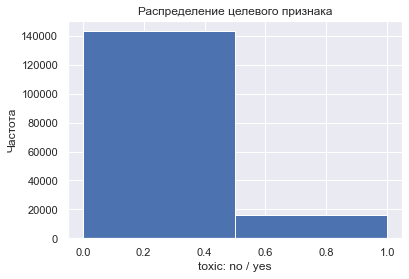

In [36]:
data['toxic'].plot(kind = 'hist', bins = 2)
plt.xlabel('toxic: no / yes')
plt.ylabel('Частота')
plt.title('Распределение целевого признака');

In [37]:
diff = data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1]
diff = np.round(diff, decimals=2)
diff

8.83

Как становится видно, негативных текстов примерно в девять раз меньше чем положительных. 

## Построение моделей  

### Выбор метрики для оценки качества моделей.

Для оценки моделей на этапе обучения будем использовать метрику F1. Она позволит более точно отследить ошибку в нашем случае с дисбалансом классов.

### Обучение моделей

Разделим выборки на тестовую и обучающую.

In [18]:
features = corpus
target = data['toxic']

In [19]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, 
                                                                            stratify=target, random_state=RS)

features_train.shape, target_train.shape, features_test.shape, target_test.shape

((127656,), (127656,), (31915,), (31915,))

### LogisticRegression

Будем использовать кросс-валидацию и следующие гиперпараметры: вес классов - сбалансированный, сила регуляризации `С` от 0.0001 до 10.

In [33]:
%%time
LR_model = LogisticRegression(class_weight = 'balanced', random_state=RS, max_iter = 300) 
pipe = Pipeline(steps=[('tf_idf', count_tf_idf), ('logistic', LR_model)])

parameters = {'logistic__C': np.linspace(0.0001, 10, 7)
             }

grid_search = GridSearchCV(pipe, parameters, scoring='f1', cv=3)
grid_search.fit(features_train, target_train)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'logistic__C': 10.0}
best scrores:  0.7569391815432566
Wall time: 4min 53s


Средний F1 на обучающей выборке = 0.757, это уже чуть больше минимально требуемого значения в 0.75.

### RandomForestClassifier

In [34]:
%%time
RFClf_model = RandomForestClassifier(class_weight = 'balanced', random_state = RS)
pipe = Pipeline(steps=[('tf_idf', count_tf_idf), ('RFClf', RFClf_model)])

parameters = {'RFClf__max_depth': np.linspace(20, 40, 3),
             'RFClf__n_estimators': range(40, 100, 30)}

grid_search = RandomizedSearchCV(pipe, parameters, 
                                 scoring= 'f1', 
                                 cv= 3, 
                                 n_iter= 2, 
                                 random_state= RS)

grid_search.fit(features_train, target_train)

print('best parameters: ', grid_search.best_params_)
print('best mean F1: ', grid_search.best_score_)

best parameters:  {'RFClf__n_estimators': 70, 'RFClf__max_depth': 30.0}
best mean F1:  0.4405602762165446
Wall time: 1min 49s


Модель случайного леса работает гораздо медленней логистической регрессии и показывает низкие результаты (лучший средний F1: 0.44). Скорее всего это связано с тем, что признаков очень много (161394), и для хорошего предсказания необходимо строить очень глубокие деревья. Однако это будет занимать очень много времени и вычислительных  ресурсов.

### XGBoost

В данном проекте мы будем использовать Sklearn API для работы с XGBoost-ом. У XGB существует DMatrix - это внутренняя структура данных, которая оптимизирована для эффективности использования памяти и для скорости обучения. Сначала попробуем использовать уже созданные нами массивы `scipy sparse csr_matrix`, а если потребуется ускорить работу модели, то перейдем к DMatrix.

Гиперпараметры к XGB будем подбирать с помощью кривых обучения. Будем смотреть как влияет количество деревьев на качество предсказания, в зависимости от величины шага градиентного спуска (learning rate). Зададим логарифмическое пространство для перебора lr.

In [49]:
a = np.geomspace(0.05, 2, 7)
a

array([0.05      , 0.09246556, 0.17099759, 0.31622777, 0.58480355,
       1.08148375, 2.        ])

Обучение XGBoost с кросс-валидацией и pipline на преобразование векторов для каждого fold-a будет очень долго и ресурсоемко. Поскольку у нас большая выборка, мы можем ожидать адекватную валидацию моделей при обычном разделении всего корпуса на трейн, валидацию и тест.
Разделим выборки в соотношении 3:1:1.

In [88]:
#сначала разделим на обучающую и временную части
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, stratify=target, random_state=RS)

#поделим временную выборку на валидационную и тестовую
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, stratify=target_temp, test_size=0.5, random_state=RS)

In [89]:
features_train.shape, target_train.shape, features_valid.shape,  target_valid.shape, features_test.shape, target_test.shape

((95742,), (95742,), (31914,), (31914,), (31915,), (31915,))

In [90]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords_set, ngram_range=(1, 1))
count_tf_idf.fit(features_train)

tf_idf_features_train = count_tf_idf.transform(features_train)
tf_idf_features_valid = count_tf_idf.transform(features_valid)
tf_idf_features_test = count_tf_idf.transform(features_test)

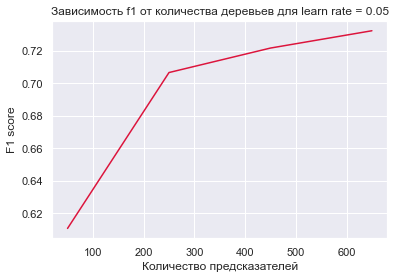

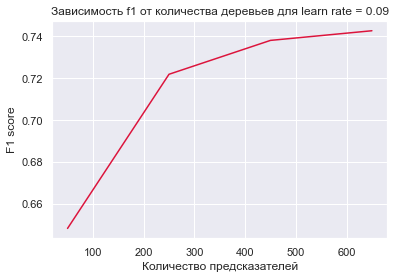

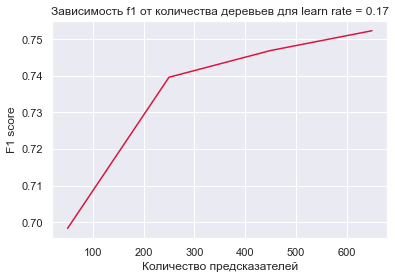

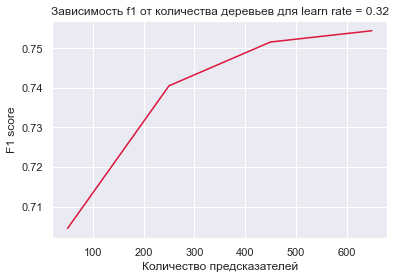

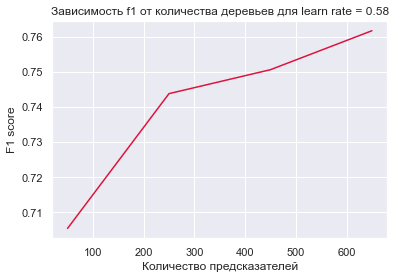

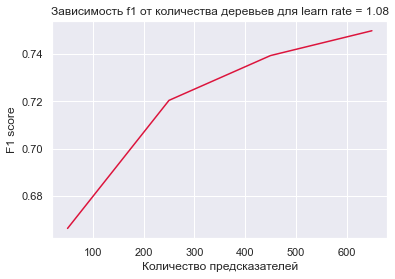

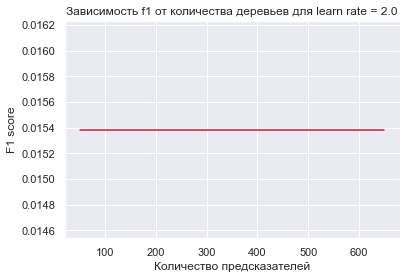

Средний F1 score наилучшей модели: 0.7616438356164384 Лучшее количество деревьев: 650 Лучший learning rate: 0.5848035476425731
Wall time: 33min 50s


In [51]:
%%time
#визуализация кривых обучения
def f1_plot(n_est_row, f1_scores, learn_r):
    lr = np.round(learn_r, decimals=2) 
    g = plt.plot(n_est_row, 
         f1_scores,  
         f'#DC143C'        
         )     

    plt.xlabel('Количество предсказателей')
    plt.ylabel('F1 score')
    plt.title(f"Зависимость f1 от количества деревьев для learn rate = {lr}")
    plt.show()

    
best_model = None
best_result = 0
best_lr = 0
best_n_est = 0
for lr in np.geomspace(0.05, 2, 7):
    n_est_row = []
    f1_scores = []
    for n_est in range(50, 651, 200):    
        XGBmodel = XGBClassifier(objective='binary:logistic', 
                      use_label_encoder=False,
                      eval_metric='logloss',
                      scale_pos_weight=diff,
                      n_estimators= n_est, 
                      max_depth= 3, 
                      learning_rate= lr, 
                      n_jobs= -1,
                      random_state = RS,
                      verbosity = 1)
        
        XGBmodel.fit(tf_idf_features_train, target_train)
        predictions = XGBmodel.predict(tf_idf_features_valid)
        
        result = f1_score(target_valid, predictions)
        n_est_row.append(n_est)
        f1_scores.append(result)
        
        if result > best_result:
            best_model = XGBmodel
            best_result = result 
            best_n_est = n_est
            best_lr = lr
            
    f1_plot(n_est_row, f1_scores, lr)
    
    
print("Средний F1 score наилучшей модели:", best_result, 
      "Лучшее количество деревьев:", best_n_est, 
      "Лучший learning rate:", best_lr)    


Графики показывают, что нужно большее количество предсказателей в нашей задаче. При lr=2 мы не спускаемся в точку минимума градиентным спуском, это слишком большой шаг. 
Зафиксируем lr = 0.58 и построим больше деревьев.

In [52]:
lr = 0.58
n_est = 650    
XGBmodel = XGBClassifier(objective='binary:logistic', 
                      scale_pos_weight=diff, 
                      use_label_encoder=False,
                      n_estimators= n_est, 
                      max_depth= 3, 
                      learning_rate= lr, 
                      n_jobs= -1,
                      random_state = RS,
                      verbosity = 1)

XGBmodel.fit(tf_idf_features_train, target_train)
predictions = XGBmodel.predict(tf_idf_features_valid)
        
result = f1_score(target_valid, predictions)

print('Validation F1:', result)

[18:35:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation F1: 0.7607843137254902


Результат начал падать. В этом проекте мы остановимся на F1 = 0.762 c 650 деревьями и learning rate 0.58, однако можно изменять масштаб перебора значений (посмотреть 600 и 700 деревьев) и, скорее всего, её улучшить F1 score. 

### Модель Логистической регрессии на эмбеддингах BERT

Разделим данные на обучающую и тестовую выборки, а также убедимся что комментарии перемешаны.

In [79]:
emb_target_train = data_4bert_train['toxic']
emb_target_val_test = data_4bert_val_ntest['toxic']
#признаки лежат в переменных embedded_features_train, embedded_features_val_test 

#разделим валидацию и тест
emb_features_validate, emb_features_test, emb_target_validate, emb_target_test = train_test_split(embedded_features_val_test, emb_target_val_test, test_size=0.5, 
                                                                            stratify=emb_target_val_test, random_state=RS)

embedded_features_train.shape, emb_features_validate.shape, emb_features_test.shape

((300, 768), (100, 768), (100, 768))

Выборки определены, переходим к обучению. Пройдемся по значаниям параметра `C` - силы регуляризации.

In [80]:
%%time

best_result = 0
best_c = 0 
for c in np.linspace(0.0001, 100, 20):
    model = LogisticRegression(C = c, class_weight = 'balanced', random_state=RS, max_iter = 500) 
    
    model.fit(embedded_features_train, emb_target_train)
    predictions = model.predict(emb_features_validate)
        
    result = f1_score(emb_target_validate, predictions)
    
    if result > best_result:
        best_model = model
        best_result = result 
        best_c = c
        
print('best C parameter: ', best_c)
print('best score: ', best_result)

best C parameter:  5.263252631578947
best score:  0.4615384615384615
Wall time: 3.1 s


Лучший F1 на валидационной выборке = 0.4615, при С = 5.26. Результат далек от  F1 > 0.75. По всей видимости логистической регрессии не хватает данных для обучения – у нас длинна 1 комментария может достигать до 512 токенов, а обучающая выборка состоит из всего 300 элементов. 

Поскольку сложность создания эмбеддингов у нас как минимум квадратичная, то при увеличении количества текстов, время будет увеличиваться в квадрате. Для нашей задачи рекомендуется использовать более легкую модель – Логистическую регрессию на TF-IDF векторах.

### Проверка моделей на тестовой выборке

`LogisticRegression с BERT`

In [92]:
%%time
model = LogisticRegression(C=5.26, class_weight = 'balanced', random_state=RS, max_iter = 500) 

model.fit(embedded_features_train, emb_target_train)
predictions = model.predict(emb_features_test)

print('F1 на тестовой выборке: {:.4f}'.format(f1_score(emb_target_test, predictions)))

F1 на тестовой выборке: 0.5455
Wall time: 189 ms


F1 модели логистической регрессии на эмбеддингах на тестовой выборке = 0.5455.

`XGBClassifier`

In [93]:
%%time
lr = 0.58
n_est = 650    
XGBmodel = XGBClassifier(objective='binary:logistic', 
                      scale_pos_weight=diff, 
                      use_label_encoder=False,
                      eval_metric='logloss',
                      n_estimators= n_est, 
                      max_depth= 3, 
                      learning_rate= lr, 
                      n_jobs= -1,
                      random_state = RS,
                      verbosity = 1)

XGBmodel.fit(tf_idf_features_train, target_train)
predictions = XGBmodel.predict(tf_idf_features_test)
        
result = f1_score(target_test, predictions)

print('Test F1:', result)

Test F1: 0.7484627484627485
Wall time: 2min 20s


F1 модели XGBClassifier  на тестовой выборке = 0.748

`LogisticRegression TF-IDF`

In [91]:
%%time
model = LogisticRegression(C=5.26, class_weight = 'balanced', random_state=RS, max_iter = 500) 

model.fit(tf_idf_features_train, target_train)
predictions = model.predict(tf_idf_features_test)

print('F1 на тестовой выборке: {:.4f}'.format(f1_score(target_test, predictions)))

F1 на тестовой выборке: 0.7547
Wall time: 8.71 s


F1 модели LogisticRegression c TF-IDF на тестовой выборке = 0.7547

### Проверка моделей на адекватность

In [94]:
dummy_model = DummyClassifier(strategy = 'stratified')
dummy_model.fit(tf_idf_features_train, target_train)
dummy_model_predictions = dummy_model.predict(tf_idf_features_test)

print('F1 DummyClf на тестовой выборке: {:.4f}'.format(f1_score(target_test, dummy_model_predictions)))

F1 DummyClf на тестовой выборке: 0.1051


Итоговый F1 dummy модели, не использующей машинное обучение, составила 0.1051. Как видим, наши модели построены не зря – они имеет большую точность (около 0.75).

### Вывод

На данном этапе мы строили различные модели и оценивали их работу.

В начале вы выбрали метрику для оценки качества моделей. Для оценки моделей на этапе обучения было решено использовать метрику F1. 
Далее мы разделили выборки на тестовую и обучающую случайным образом, в соотношении 4:1.

3.1. LogisticRegression  
При обучении и подборе гиперпарметров мы использовали кросс-валидацию и следующие гиперпараметры: вес классов - сбалансированный, сила регуляризации от 0.0001 до 10.  
Средний F1 на обучающей выборке был равен 0.758, это уже позволило достичь минимально требуемого значения в 0.75.

3.2. RandomForestClassifier  
Было обнаружено, что в данной задаче модель случайного леса работает гораздо медленней логистической регрессии и показывает низкие результаты (лучший средний F1: 0.42). Скорее всего это связано с тем, что признаков очень много (161394), и для хорошего предсказания необходимо строить очень глубокие деревья. Однако это будет занимать очень много времени и вычислительных ресурсов.

3.3. XGBoost  
В данном проекте мы использовали XGBoost sklearn API. 
Гиперпараметры к XGB было решено подбирать с помощью кривых обучения. Будем смотреть как влияет количество деревьев на качество предсказания, в зависимости от величины шага градиентного спуска (learning rate). Для перебора lr и использовали логарифмическое пространство от 0.05 до 1.
На первой итерации мы получили лучший средний F1: 0.7295. После этого мы зафиксировали lr и построили больше деревьев. 
Мы получили средний F1: 0.747 при 700 деревьев, было решено остановиться на нем, однако можно было увеличивать learnning rate и ещё улучшить результат.

3.4. Модель Логистической регрессии на эмбеддингах BERT  
Лучший F1 на валидационной выборке = 0.4615, при С = 5.26. Результат далек от F1 > 0.75. По всей видимости логистической регрессии не хватает данных для обучения – у нас длинна 1 комментария может достигать до 512 токенов, а обучающая выборка состоит из всего 300 элементов.

3.5. Далее мы проверили модель на тестовой выборке
F1-score модели логистической регрессии на эмбеддингах на тестовой выборке = 0.8367.

3.6. В конце была проведена проверка моделей на адекватность  
Итоговый F1 dummy модели, не использующей машинное обучение, составила 0.57. Как видим, наша модель построена не зря – она имеет большую точность (около 0.8367).

Если нам необходимо будет проверять сообщения в реальном времени, то пропускной способности обрабатывать 500 текстов за 3 минуты может быть не достаточно. Поскольку сложность у нас как минимум квадратичная, то при увеличении количества текстов, время будет увеличиваться в квадрате. В этом случае рекомендуется использовать более легкую модель – Логистическую регрессию на TF-IDF векторах.

## Общий вывод

**1.** На первом шаге мы подготовили наши данные для дальней работы. 
1. Загрузили данные. Всего для анализа было получено 159571 комментариев и их тональности.
2. Проверили дубликаты и пропуски.
3. Произвели лемматизацию текста с помощью Wordnet Lemmatizer (с тэггером части речи POS).
4. Векторизовали тексты через TF-IDF для N-грамм слов.
5. Создали эмбеддинги с помощью DistilBERT. Для анализа мы взяли 500 случайных комментариев. Отметим, что для создания эмбеддингов для 500 текстов нам потребовалось 3 минуты. Мы оценили что вычислительная сложность модели как минимум квадратичная.

**2.** На втором этапе мы проанализировали наши данные.
- Проверили распределение целевого признака, 
- уточнили задачу обучения – бинарная классификация, 
- а также создали переменную для придания веса классам в целевом признаке.

**3.** Третий этап был посвящен обучению моделей и их оценке.

В начале вы выбрали метрику для оценки качества моделей. Для оценки моделей на этапе обучения было решено использовать метрику F1. 
Далее мы разделили выборки на тестовую и обучающую случайным образом, в соотношении 4:1.

3.1. LogisticRegression  
При обучении и подборе гиперпарметров мы использовали кросс-валидацию и следующие гиперпараметры: вес классов - сбалансированный, сила регуляризации от 0.0001 до 10.  
Средний F1 на обучающей выборке был равен 0.758, это уже позволило достичь минимально требуемого значения в 0.75.

3.2. RandomForestClassifier  
Было обнаружено, что в данной задаче модель случайного леса работает гораздо медленней логистической регрессии и показывает низкие результаты (лучший средний F1: 0.42). Скорее всего это связано с тем, что признаков очень много (161394), и для хорошего предсказания необходимо строить очень глубокие деревья. Однако это будет занимать очень много времени и вычислительных ресурсов.

3.3. XGBoost  
В данном проекте мы использовали XGBoost sklearn API. 
Гиперпараметры к XGB было решено подбирать с помощью кривых обучения. Будем смотреть как влияет количество деревьев на качество предсказания, в зависимости от величины шага градиентного спуска (learning rate). Для перебора lr и использовали логарифмическое пространство от 0.05 до 1.
На первой итерации мы получили лучший средний F1: 0.7295. После этого мы зафиксировали lr и построили больше деревьев. 
Мы получили средний F1: 0.747 при 700 деревьев, было решено остановиться на нем, однако можно было увеличивать learnning rate и ещё улучшить результат.

3.4. Модель Логистической регрессии на эмбеддингах BERT  
Лучший F1 на валидационной выборке = 0.4615, при С = 5.26. Результат далек от F1 > 0.75. По всей видимости логистической регрессии не хватает данных для обучения – у нас длинна 1 комментария может достигать до 512 токенов, а обучающая выборка состоит из всего 300 элементов.

Если нам необходимо будет проверять сообщения в реальном времени, то пропускной способности обрабатывать 500 текстов за 3 минуты может быть не достаточно. Поскольку сложность у нас как минимум квадратичная, то при увеличении количества текстов, время будет увеличиваться в квадрате. В этом случае рекомендуется использовать более легкую модель – Логистическую регрессию на TF-IDF векторах.


Таблица результатов:

Модель | F1 score | Время предсказания
:---|---|---
**Логистическая регрессия** | 0.755  | 9 s   
**Случайный лес** | 0.44  | 19 s
**XGBoost** | 0.748  | 2 min
**BERT + Лог. регрессия** | 0.545  | 3 min

3.5. Далее мы проверили лучшую модель на тестовой выборке.  
F1-score модели логистической регрессии на эмбеддингах на тестовой выборке = 0.8367.

3.6. В конце была проведена проверка моделей на адекватность.  
Итоговый F1 dummy модели, не использующей машинное обучение, составила  0.105. Как видим, наши модели построены не зря – они имеют большую точность (до 0.755).
